In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#load moduels
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
from datacube import helpers

import gdal

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from affine import Affine
import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [12]:
#define filepath to Geomedian NetCDF input and output

file_to_open = '/g/data/u46/users/dxr251/woody-v6/woody_62_-151.tif'

output_file = '/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/TEsT.nc'

#define the file location of the training dataset 

training_file = '/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/NCAS_trained_GM_two_1.csv'

In [4]:
help(xr.open_rasterio)

Help on function open_rasterio in module xarray.backends.rasterio_:

open_rasterio(filename, parse_coordinates=None, chunks=None, cache=None, lock=None)
    Open a file with rasterio (experimental).
    
    This should work with any file that rasterio can open (most often:
    geoTIFF). The x and y coordinates are generated automatically from the
    file's geoinformation, shifted to the center of each pixel (see
    `"PixelIsArea" Raster Space
    <http://web.archive.org/web/20160326194152/http://remotesensing.org/geotiff/spec/geotiff2.5.html#2.5.2>`_
    for more information).
    
    You can generate 2D coordinates from the file's attributes with::
    
        from affine import Affine
        da = xr.open_rasterio('path_to_file.tif')
        transform = Affine(*da.attrs['transform'])
        nx, ny = da.sizes['x'], da.sizes['y']
        x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
    
    
    Parameters
    ----------
    filename : str
        Path to 

In [24]:

#load geomedian into a xr dataset
smad_dataset = xr.open_rasterio(file_to_open, parse_coordinates=True)

crs = datacube.utils.geometry.CRS(smad_dataset.crs.split('=')[1])
del smad_dataset.attrs['crs']
smad_dataset.attrs['crs'] = crs

In [20]:
smad_dataset

<xarray.DataArray (band: 3, y: 1000, x: 1000)>
[3000000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -3.75e+06 -3.75e+06 -3.75e+06 -3.75e+06 -3.75e+06 ...
  * x        (x) float64 1.55e+06 1.55e+06 1.55e+06 1.55e+06 1.55e+06 ...
Attributes:
    transform:   (25.0, 0.0, 1550000.0, 0.0, -25.0, -3750000.0, 0.0, 0.0, 1.0)
    res:         (25.0, 25.0)
    is_tiled:    1
    nodatavals:  (nan, nan, nan)
    crs:         epsg:3577

In [6]:
#we are now going to bake a mask that masks out all instances of Nan in the Geomedian. 
#Nan in the geomedian indicates perminant waterbodies or rarely perminant cloud cover. 
#the classifing algorithm can not handle nan, so we will later be changing all the nan values to 0. 


#invalid_mask = np.isnan(Geomedian_dataset.red.squeeze())

#later mask where this is ture


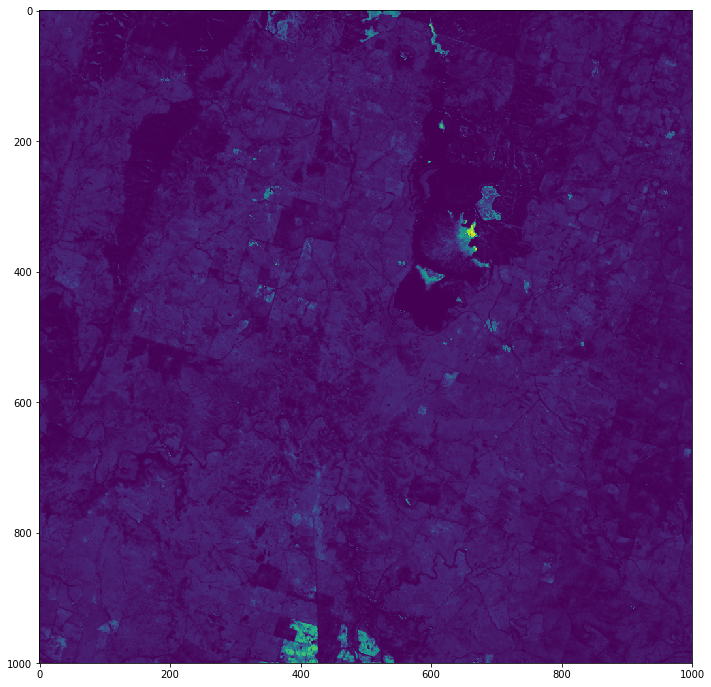

In [7]:
#view your awsone classification output
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(smad_dataset[0])

plt.show()

In [9]:
#transform the dataset into the format needed to feed to the machine learning algorithm, a 'flat' array with shape [(x,y),bands]
#we combine axies x and y into one new dimention called z

smad_flat = smad_dataset.stack(z=('x','y'))
#smad_flat = smad_flat.to_array()
smad_flat = smad_flat.transpose()

smad_flat = smad_flat.fillna(0)

In [10]:
smad_flat

<xarray.DataArray (z: 1000000, band: 3)>
array([[0.029841, 0.735876, 0.594835],
       [0.038459, 0.748197, 0.585555],
       [0.024847, 0.743935, 0.604042],
       ...,
       [0.028203, 0.674615, 0.604254],
       [0.031728, 0.653964, 0.589978],
       [0.025046, 0.61933 , 0.552153]], dtype=float32)
Coordinates:
  * band     (band) int64 1 2 3
  * z        (z) MultiIndex
  - x        (z) float64 1.55e+06 1.55e+06 1.55e+06 1.55e+06 1.55e+06 ...
  - y        (z) float64 -3.75e+06 -3.75e+06 -3.75e+06 -3.75e+06 -3.75e+06 ...
Attributes:
    transform:   (25.0, 0.0, 1550000.0, 0.0, -25.0, -3750000.0, 0.0, 0.0, 1.0)
    crs:         +init=epsg:3577
    res:         (25.0, 25.0)
    is_tiled:    1
    nodatavals:  (nan, nan, nan)

In [10]:
#load traning data from file 

training_data = pd.read_csv(training_file)
training_data

,Unnamed: 0,class,red,blue,green,rededge1,rededge2,rededge3,nir1,nir2,swir1,swir2
0,0,1,789.072560,569.215527,733.625553,1136.248934,2014.036523,2252.125539,2699.660338,2557.503778,1963.906536,1281.260957
1,1,0,643.766242,483.059501,643.795675,1011.880807,1865.895384,2112.301137,2546.564296,2367.722690,1881.406317,1133.833005
2,2,0,554.487748,429.235907,536.344387,929.294677,1548.239430,1754.232130,1802.979115,1999.020461,1828.330495,1127.178677
3,3,1,494.399595,369.002308,468.365681,815.449215,1549.396754,1771.562660,1800.859597,2005.717843,1435.026338,839.249374
4,4,1,624.752537,448.751666,574.516617,1024.068567,1880.864894,2108.048007,2377.732315,2384.667945,1723.681687,1098.044039
5,5,0,1003.272344,586.898194,776.998135,1169.846137,1649.297248,1824.135425,2196.300867,2044.883629,2233.309319,1604.715081
6,6,0,694.949972,494.155074,614.523703,924.691342,1484.857643,1692.559808,1940.178307,1906.416252,1804.685304,1151.453061
7,7,1,556.533765,426.659977,522.708025,884.760302,1487.637839,1695.410244,1969.572986,1892.404269,1663.808833,1041.874814
8,8,1,480.199946,366.659920,480.892626,801.774747,1340.550267,1511.387546,1561.235059,1709.195055,1581.053888,994.657781
9,9,1,472.188010,355.274617,480.316226,831.101493,1533.737913,1709.417173,1813.717853,1955.276127,1553.929764,972.221196


In [11]:
training_data = training_data.replace([np.inf, -np.inf], np.nan)
training_data = training_data.dropna(axis=0)
training_data

,Unnamed: 0,class,red,blue,green,rededge1,rededge2,rededge3,nir1,nir2,swir1,swir2
0,0,1,789.072560,569.215527,733.625553,1136.248934,2014.036523,2252.125539,2699.660338,2557.503778,1963.906536,1281.260957
1,1,0,643.766242,483.059501,643.795675,1011.880807,1865.895384,2112.301137,2546.564296,2367.722690,1881.406317,1133.833005
2,2,0,554.487748,429.235907,536.344387,929.294677,1548.239430,1754.232130,1802.979115,1999.020461,1828.330495,1127.178677
3,3,1,494.399595,369.002308,468.365681,815.449215,1549.396754,1771.562660,1800.859597,2005.717843,1435.026338,839.249374
4,4,1,624.752537,448.751666,574.516617,1024.068567,1880.864894,2108.048007,2377.732315,2384.667945,1723.681687,1098.044039
5,5,0,1003.272344,586.898194,776.998135,1169.846137,1649.297248,1824.135425,2196.300867,2044.883629,2233.309319,1604.715081
6,6,0,694.949972,494.155074,614.523703,924.691342,1484.857643,1692.559808,1940.178307,1906.416252,1804.685304,1151.453061
7,7,1,556.533765,426.659977,522.708025,884.760302,1487.637839,1695.410244,1969.572986,1892.404269,1663.808833,1041.874814
8,8,1,480.199946,366.659920,480.892626,801.774747,1340.550267,1511.387546,1561.235059,1709.195055,1581.053888,994.657781
9,9,1,472.188010,355.274617,480.316226,831.101493,1533.737913,1709.417173,1813.717853,1955.276127,1553.929764,972.221196


In [12]:
#split the training data into two arrays: an array for the features and an array for the classifications. this is what we
#will directly use to train the classifier

training_features = training_data.as_matrix(columns=['blue', 'green','red', 'rededge1', 'rededge2', 'rededge3', 
                                                     'nir1', 'nir2', 'swir1', 'swir2']).astype(np.float) #create Array of features for training
training_class = training_data.as_matrix(columns=['class']).astype(np.float) #create Array of classification answer for training
training_class

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [13]:

np.all(np.isfinite(training_features))

True

In [14]:
#define machine learning algarithm 
Actuall_classifier = ExtraTreesClassifier(n_estimators=250, bootstrap=True, oob_score=True, random_state=0)
#250 estimators takes longer than default (10) but does a better job.
#n_jobs makes trees run in parralell, uses more memory but increases speed. 

Actuall_classifier.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [15]:
#classify input data using trained classifier
results=Actuall_classifier.predict(Geomedian_flat)

In [22]:
#reshape results and turn into an XR array with appropreate dimentions/data type to re-join the GM dataset. 
results_back = results.reshape(10000,10000)
results_xr = xr.DataArray(results_back,dims=('x', 'y'),name='results')
results_xr = results_xr.astype('float32')
results_xr = results_xr.transpose()

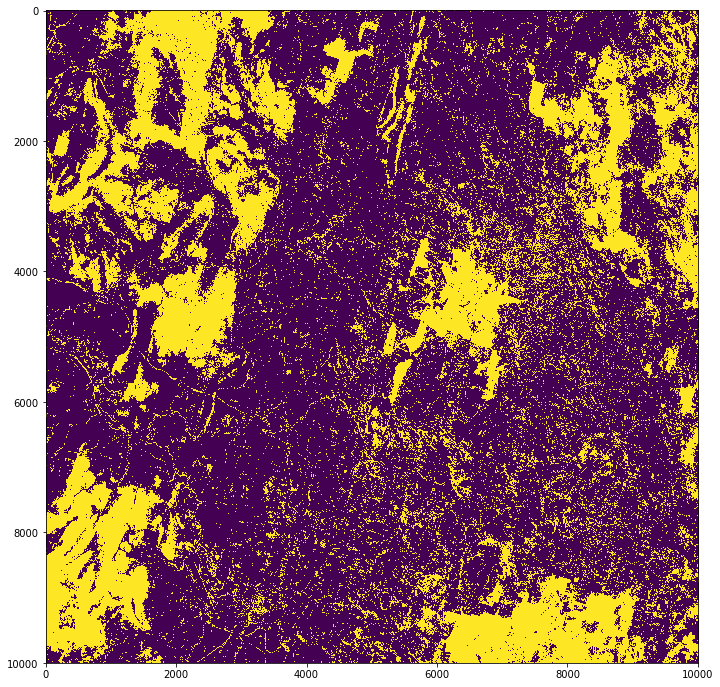

In [23]:
#view your awsone classification output
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)

plt.show()

In [25]:
#add classification results to dataset
##replace with Geomediam 
Geomedian_dataset["class"] = results_xr
Geomedian_dataset["no_data"] = xr.DataArray(invalid_mask, dims=('x','y'), name='no_data')
Geomedian_dataset
#add smad/green to dataset?

<xarray.Dataset>
Dimensions:   (time: 1, x: 10000, y: 10000)
Coordinates:
  * x         (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * y         (y) float64 -3.7e+06 -3.7e+06 -3.7e+06 -3.7e+06 -3.7e+06 ...
  * time      (time) datetime64[ns] 2015-01-01
Data variables:
    blue      (time, y, x) float32 537.0 544.0 544.0 541.0 538.0 537.0 541.0 ...
    green     (time, y, x) float32 838.0 837.0 838.0 831.0 840.0 838.0 839.0 ...
    red       (time, y, x) float32 1233.0 1226.0 1228.0 1225.0 1226.0 1230.0 ...
    rededge1  (time, y, x) float32 1601.0 1591.0 1589.0 1582.0 1580.0 1566.0 ...
    rededge2  (time, y, x) float32 2052.0 2046.0 2046.0 2045.0 2045.0 2029.0 ...
    rededge3  (time, y, x) float32 2223.0 2212.0 2212.0 2213.0 2213.0 2193.0 ...
    nir1      (time, y, x) float32 2347.0 2367.0 2383.0 2370.0 2369.0 2357.0 ...
    nir2      (time, y, x) float32 2502.0 2503.0 2502.0 2504.0 2504.0 2486.0 ...
    swir1     (time, y, x) float32 3222.0 3210.0 3207.0 3200.0

In [27]:
smad_dataset.crs.dimensions[1]

'x'

In [18]:
helpers.write_geotiff(output_file, smad_dataset)

TypeError: tuple indices must be integers or slices, not str

In [21]:
smad_dataset.to_netcdf(output_file,'w','NETCDF4')

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


NameError: name 'datacube' is not defined